In [85]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from FLOPs_counter import *

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/Users/nowmicaamatheswaran/Downloads/animal/dataset/dataset'
classes = os.listdir(data_dir)

In [89]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [91]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [93]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [95]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


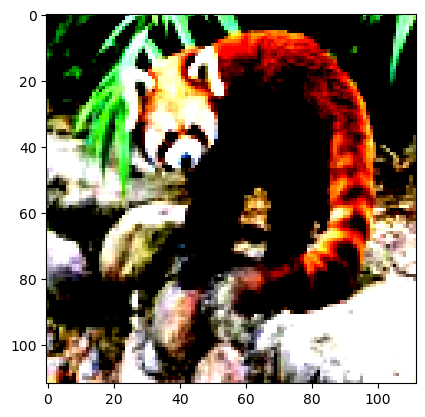

In [97]:
show_image(*dataset[200])

In [99]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [101]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

In [103]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


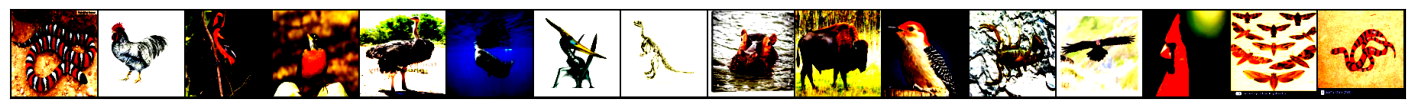

In [105]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [106]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [107]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [108]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [113]:
input_size = 3*112*112
output_size = 151

In [31]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [33]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model = to_device(model, device)
model
#model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [35]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0255, -5.0079, -4.9624, -5.0601, -5.0815, -4.9867, -5.0010, -4.9866,
        -5.0674, -5.0150, -5.0687, -4.9801, -4.9815, -5.0259, -5.0536, -5.0305,
        -5.0421, -5.0115, -5.0338, -5.0770, -5.0104, -5.0112, -5.0255, -4.9587,
        -4.9997, -4.9617, -4.9564, -5.0809, -5.0269, -4.9684, -4.9687, -5.0344,
        -5.0872, -5.0055, -5.0148, -4.9943, -5.0245, -4.9980, -4.9084, -5.0188,
        -5.0612, -5.0371, -5.0037, -5.0825, -4.9323, -5.0399, -5.0154, -5.0931,
        -5.0153, -5.0073, -5.0277, -5.0495, -4.9887, -5.0753, -5.0230, -5.0767,
        -5.0536, -5.0430, -5.0373, -4.9685, -5.0563, -5.0232, -5.0480, -5.0434,
        -5.0576, -4.9811, -5.0383, -5.0473, -5.0285, -5.0213, -5.0454, -5.0055,
        -5.0272, -5.0746, -5.0667, -5.0843, -5.0347, -4.9943, -5.0220, -4.9649,
        -5.0838, -5.0008, -5.0464, -4.9693, -4.9921, -4.9639, -5.0433, -5.0285,
        -5.0358, -5.0497, -5.0519, 

In [115]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)


In [117]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
#model = to_device(model, device)

In [43]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015682220458984, 'val_acc': 0.02187499962747097}]

In [45]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [47]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7659, val_loss: 4.4881, val_acc: 0.0844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.1715, val_loss: 4.1295, val_acc: 0.2285


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.6470, val_loss: 3.9481, val_acc: 0.2816


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.1821, val_loss: 3.7555, val_acc: 0.3177


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7552, val_loss: 3.8595, val_acc: 0.3153


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.3584, val_loss: 3.9426, val_acc: 0.3559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.9736, val_loss: 4.1496, val_acc: 0.4052


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6311, val_loss: 4.4640, val_acc: 0.3934


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.3663, val_loss: 4.5857, val_acc: 0.3628


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0934, val_loss: 4.8798, val_acc: 0.3910


In [63]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

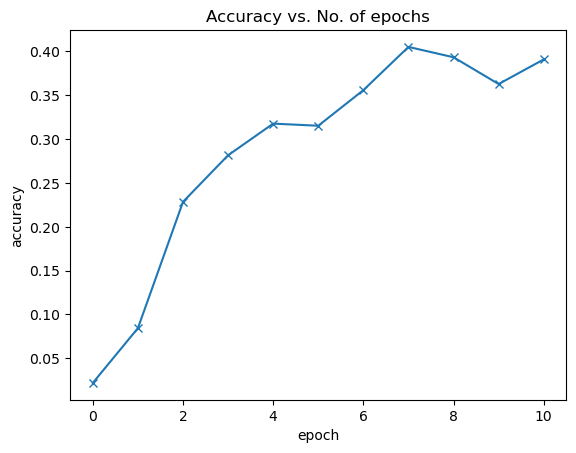

In [51]:
plot_accuracies(history)

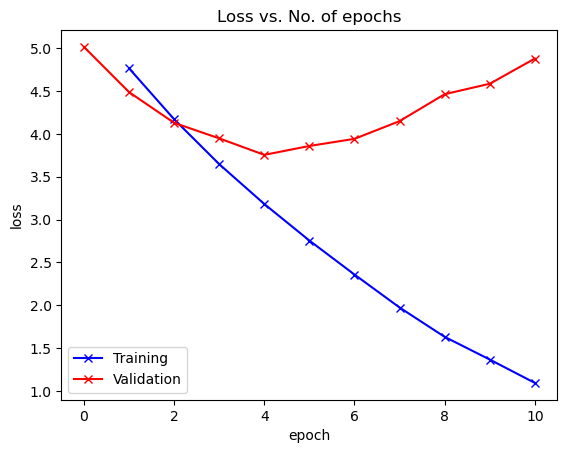

In [53]:
plot_losses(history)

In [55]:
evaluate(model, test_loader)

{'val_loss': 5.0735979080200195, 'val_acc': 0.37708336114883423}

In [59]:
# Generate random input tensor with the same size as the training images
input_tensor = torch.randn(1, 3, 112, 112).to(device)

# Calculate FLOPs using the function from flops.py
print_model_parm_flops(model, input_tensor, detail=True)

 + Number of FLOPs: 0.69G
  + Conv FLOPs: 0.69G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.00G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [61]:
final_accuracy = 37.70
flops = 0.69
efficiency = final_accuracy/flops
print(efficiency)

54.637681159420296


In [64]:
class ConvolutionalNetworkUpdated(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes
        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*5*5, self.num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 128*5*5)
        X = self.dropout(X)  # Apply dropout
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [66]:
num_classes = 151
model_updated = ConvolutionalNetworkUpdated(num_classes)

In [68]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
model_updated = to_device(model_updated, device)

In [70]:
history = [evaluate(model_updated, val_loader)]
history

[{'val_loss': 5.017353057861328, 'val_acc': 0.02500000037252903}]

In [75]:
num_epochs_updated = 20
opt_func = torch.optim.Adam
lr_updated = 0.0001

In [77]:
history+= fit(num_epochs_updated, lr_updated, model_updated, train_dl, val_dl, opt_func)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7763, val_loss: 4.1885, val_acc: 0.1830


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.0460, val_loss: 3.8490, val_acc: 0.2934


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.6224, val_loss: 3.5336, val_acc: 0.3646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.3176, val_loss: 3.4411, val_acc: 0.3684


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.0382, val_loss: 3.3017, val_acc: 0.4170


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7735, val_loss: 3.0875, val_acc: 0.4569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5737, val_loss: 3.0479, val_acc: 0.4708


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.4071, val_loss: 2.9655, val_acc: 0.4670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.2328, val_loss: 2.9187, val_acc: 0.5045


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.1009, val_loss: 2.8464, val_acc: 0.5170


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.9653, val_loss: 2.8584, val_acc: 0.5083


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.8765, val_loss: 2.7484, val_acc: 0.5382


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.7427, val_loss: 2.8289, val_acc: 0.5233


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.6422, val_loss: 2.7899, val_acc: 0.5295


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.5355, val_loss: 2.6489, val_acc: 0.5569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.4729, val_loss: 2.6604, val_acc: 0.5569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.3693, val_loss: 2.5775, val_acc: 0.5795


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.2885, val_loss: 2.6083, val_acc: 0.5538


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.2420, val_loss: 2.5678, val_acc: 0.5694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.1757, val_loss: 2.6873, val_acc: 0.5569


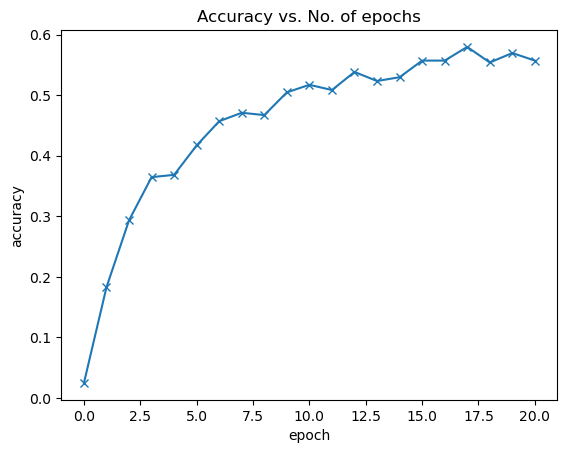

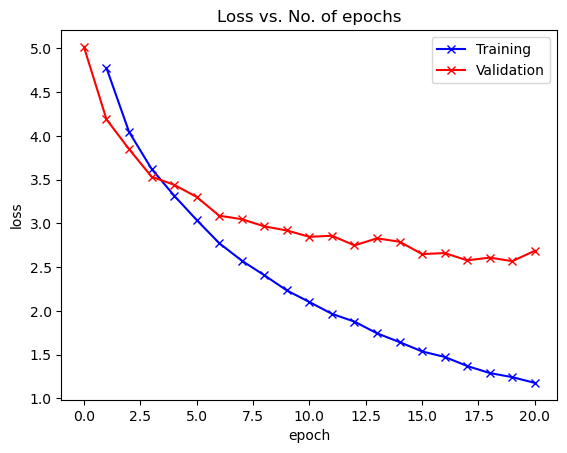

{'val_loss': 2.581291675567627, 'val_acc': 0.5848958492279053}

In [79]:
plot_accuracies(history)
plot_losses(history)
evaluate(model_updated, test_loader)

In [81]:
# Generate random input tensor with the same size as the training images
input_tensor = torch.randn(1, 3, 112, 112).to(device)

# Calculate FLOPs using the function from flops.py
print_model_parm_flops(model_updated, input_tensor, detail=True)

 + Number of FLOPs: 0.69G
  + Conv FLOPs: 0.69G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.00G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [83]:
final_accuracy = 58.48
flops = 0.69
efficiency = final_accuracy/flops
print(efficiency)

84.7536231884058


In [31]:
train_transform_updated = transforms.Compose([
    transforms.Resize(224),  # Resize to match pre-trained model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize to match pre-trained model
])

In [33]:
dataset_updated = ImageFolder(data_dir, transform=train_transform_updated)

In [35]:
torch.manual_seed(10)
val_size = len(dataset_updated)//20
test_size = len(dataset_updated)//10
train_size = len(dataset_updated) - val_size - test_size

In [37]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

In [39]:
batch_size = 32  # Increased batch size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [41]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [43]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [45]:
class ResNetTransferLearning(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)  # Load a pre-trained ResNet model
        in_features = self.resnet.fc.in_features  # Get the number of input features for the final layer
        self.resnet.fc = nn.Linear(in_features, num_classes)  # Replace the final layer

    def forward(self, x):
        return self.resnet(x)

In [47]:
num_classes = 151
model_resnet = ResNetTransferLearning(num_classes)

# Move model to the device
model_resnet = to_device(model_resnet, device)

In [53]:
num_epochs_tl = 10
opt_func_tl = torch.optim.Adam
lr_tl = 0.001  # Adjust learning rate

history_tf = [evaluate(model_resnet, val_loader)]
history_tf

[{'val_loss': 5.477362632751465, 'val_acc': 0.015625}]

In [59]:
history_tf+= fit(num_epochs_tl, lr_tl, model_resnet, train_dl, val_dl, opt_func_tl)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.6748, val_loss: 3.9526, val_acc: 0.3556


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.3302, val_loss: 3.4279, val_acc: 0.5118


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.7031, val_loss: 2.8750, val_acc: 0.5296


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2219, val_loss: 2.2120, val_acc: 0.6578


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.9486, val_loss: 2.1889, val_acc: 0.6894


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6480, val_loss: 2.2893, val_acc: 0.7099


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4918, val_loss: 2.2908, val_acc: 0.6911


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4608, val_loss: 2.0592, val_acc: 0.7309


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.3800, val_loss: 2.4018, val_acc: 0.6934


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.3045, val_loss: 2.2881, val_acc: 0.7237


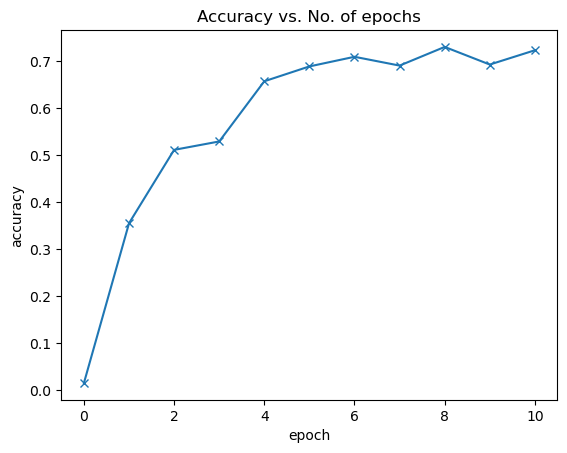

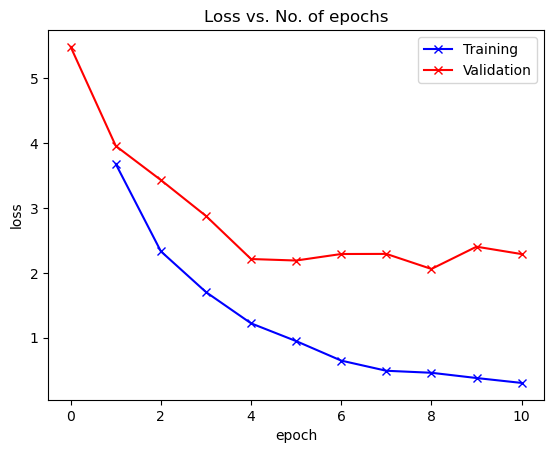

{'val_loss': 2.0776374340057373, 'val_acc': 0.7447368502616882}

In [65]:
plot_accuracies(history_tf)
plot_losses(history_tf)
evaluate(model_resnet, test_loader)

In [119]:
# Generate random input tensor with the same size as the training images
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Calculate FLOPs using the function from flops.py
print_model_parm_flops(model_resnet, input_tensor, detail=True)

 + Number of FLOPs: 3.59G
  + Conv FLOPs: 3.57G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.01G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [123]:
final_accuracy = 74.47
flops = 3.59
efficiency = final_accuracy/flops
print(efficiency)

20.74373259052925


In [66]:
class ResNetTransferLearningUpdated(ImageClassificationBase):
    def __init__(self, num_classes, dropout_prob=0.5):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),   # Batch Norm layer
            nn.Dropout(dropout_prob),      # Dropout layer
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [69]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)


In [71]:
def fit_lr_update(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in tqdm(range(epochs)):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Check for early stopping
        early_stopping(result['val_loss'])
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch}')
            break

    return history

In [73]:
num_classes = 151
model_resnet_updated = ResNetTransferLearningUpdated(num_classes)

# Move model to the device
model_resnet_updated = to_device(model_resnet_updated, device)
model_resnet_updated

ResNetTransferLearningUpdated(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [75]:
num_epochs_tl_update = 10 
opt_func_tl_update = torch.optim.Adam
lr_tl_update = 0.0001

history_tf_update = [evaluate(model_resnet_updated, val_loader)]
history_tf_update

[{'val_loss': 5.820176124572754, 'val_acc': 0.01875000074505806}]

In [77]:
history_tf_update += fit_lr_update(num_epochs_tl_update, lr_tl_update, model_resnet_updated, train_loader, val_loader, opt_func_tl_update)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.1986, val_loss: 2.9866, val_acc: 0.6488


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.4118, val_loss: 2.0875, val_acc: 0.7840


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.5146, val_loss: 1.6119, val_acc: 0.8255


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.9497, val_loss: 1.3652, val_acc: 0.8514


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5941, val_loss: 1.2551, val_acc: 0.8608


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3609, val_loss: 1.1460, val_acc: 0.8648


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2390, val_loss: 1.1399, val_acc: 0.8701


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1586, val_loss: 1.0391, val_acc: 0.8804


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1023, val_loss: 0.9987, val_acc: 0.8866


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0738, val_loss: 1.0337, val_acc: 0.8773


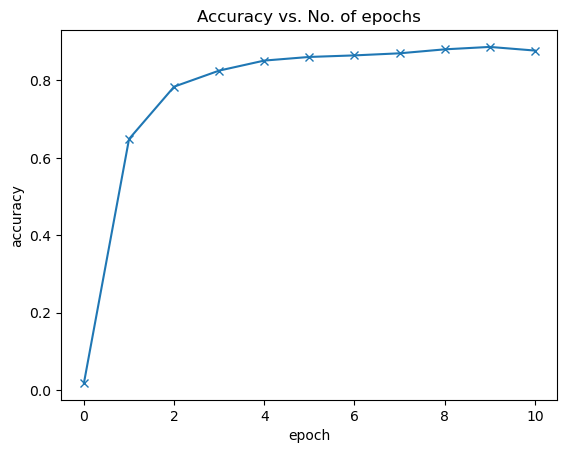

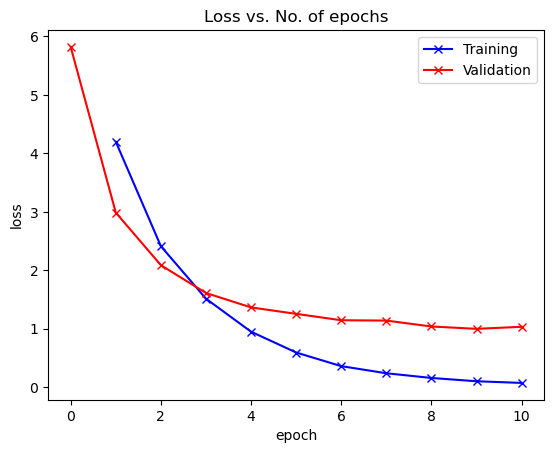

{'val_loss': 0.9022741317749023, 'val_acc': 0.9197368621826172}

In [78]:
plot_accuracies(history_tf_update)
plot_losses(history_tf_update)
evaluate(model_resnet_updated, test_loader)

In [81]:
# Generate random input tensor with the same size as the training images
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Calculate FLOPs using the function from flops.py
print_model_parm_flops(model_resnet_updated, input_tensor, detail=True)

 + Number of FLOPs: 3.59G
  + Conv FLOPs: 3.57G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.01G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [83]:
final_accuracy = 91.97
flops = 3.59
efficiency = final_accuracy/flops
print(efficiency)

25.618384401114206
